In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge                    #LIBRERIAS NECESARIAS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0) #Con estea semilla podemos volver a generar de la misma forma los datos.

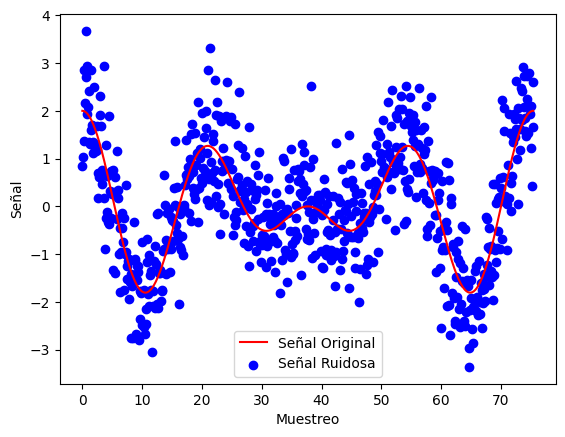

In [5]:
def var_snr(x,snrdB): #Función que entrega el varianza del ruido tomando en cuenta su potencia en dB
    Px = np.mean(x**2)
    return Px/(10**(snrdB/10))

snrdB = 2
N = 700 #Muestras 500 de entrenamiento + 200 de testeo

X = np.linspace(0, 24*np.pi, N)  #array de tiempo
Y_true = np.cos(X/3)+np.cos(X/4)  #señal limpia de cosenos

var_noise = var_snr(Y_true, snrdB) #Hallar varianza del ruido

Y = Y_true + np.random.normal(0, np.sqrt(var_noise), len(X)) #Señal contaminada con ruido gaussiano media 0, varianza var_noise

X = X.reshape(-1,1) #Sklearn sólo entiendo en vectores columna, por esto mismo transformamos los datos de fila a columna
Y = Y.reshape(-1,1)

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.scatter(X, Y, c='b', label='Señal Ruidosa')
plt.legend()
plt.xlabel('Muestreo')
plt.ylabel('Señal')
plt.show()

In [6]:
scaler_X = MinMaxScaler() #Creamos2 dos variables que contienen los modelos de normalización
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X) #Normalizamos los valores en un rango de [0,1]
Y_scaled = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=200/N, random_state=42) #Dividimos nuestros datos 500 train 200 test
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(500, 1) (200, 1) (500, 1) (200, 1)


## Máxima Verosimilitud con Ridge

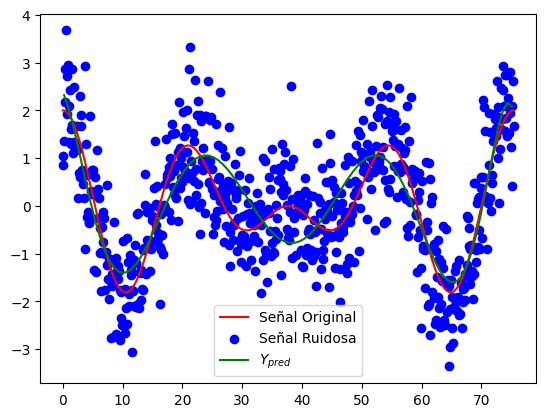

In [7]:
def maxLight(X_train, X_test, Y_train, Y_test, lambdaR, Q):

    phiQ = PolynomialFeatures(degree=Q)  #Matriz polinomial Phi de grado Q
    X_train_phi = phiQ.fit_transform(X_train) #Ajusta (fit) el transformador a los datos en entrada y luego (transform) los transforma
    
    ridge = Ridge(alpha=lambdaR) #Modelo de regresión lineal regularizada para hallar la función de costo
    ridge.fit(X_train_phi, Y_train)

    X_test_line = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1) #arreglo de tiempo para visualizar nuestros datos predichos de manera lineal 1D
    X_test_line_phi = phiQ.transform(X_test_line)
    Y_pred_line = ridge.predict(X_test_line_phi)
    
    return X_test_line, Y_pred_line

x_minc, y_minc = maxLight(X_train, X_test, Y_train, Y_test, 1e-10, 9)

plt.plot(X, Y_true, c='r', label='Señal Original')
plt.scatter(X, Y, c='b', label='Señal Ruidosa')
plt.plot(scaler_X.inverse_transform(x_minc), scaler_Y.inverse_transform(y_minc), c='g', label='$Y_{pred}$')
plt.legend()
plt.show()   

## Máxima Verosimilitud con np.linalg.pinv()

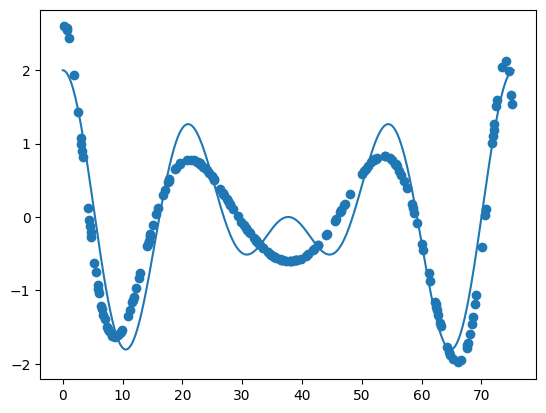

In [86]:
def maxlight_pinv(X_train, X_test, Y_train, Y_test, Q):
    poly = PolynomialFeatures(degree=Q)

    X_train_poly = poly.fit_transform(X_train)  # Aplicar la transformación polinomial a los datos X
    X_test_poly = poly.fit_transform(X_test)

    theta = np.linalg.pinv(X_train_poly) @ Y_train  # Ahora se puede realizar la multiplicación

    return X_test_poly @ theta  # Predicción utilizando los coeficientes óptimos

Y_pred = maxlight_pinv(X_train, X_test, Y_train, Y_test, 10)

plt.plot(X,Y_true)
plt.scatter(scaler_X.inverse_transform(X_test), scaler_Y.inverse_transform(Y_pred))
plt.show()

## Máximo a Posteriori